# Quantum Imaginary Time Evolution ab initio

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

In [15]:
# sys.path.append("../interactions/")
interaction_filename="../interactions/Daejeon16_Nmax40_hw15.0_rel.dat"
H = hamiltonian_matrix(Nmax=4,hw=15.0,J=1,interaction_filename=interaction_filename) 
H_qubit = GrayCodeHamiltonian(H)
eig_exact,_=eigh(H)
eig_q,_=eigh(H_qubit.matrix)
print(f"N qubits: {H_qubit.N_qubits}")
print(eig_exact[0])
print(eig_q[0])

H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
eig_q2,_=eigh(H_qubit.matrix)
print(eig_q2[0])



N qubits: 3
-1.8460233327408204
-1.8460233327408346
-2.0456708984064313


In [16]:
## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits
## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])




XX ['II', 'IX', 'XI', 'XX'] XX
XY ['IY', 'XY'] YX
XZ ['IZ', 'XZ'] ZX
YX ['YI', 'YX'] XY
YY ['YY'] YY
YZ ['YZ'] ZY
ZX ['ZI', 'ZX'] XZ
ZY ['ZY'] YZ
ZZ ['ZZ'] ZZ


## Prepare and run the evolution circuit for Gray code encoding  

Testing threshold used when solving for A

In [21]:
# num_iterations=5
num_iterations=20
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table=[]
interaction_filename="../interactions/Daejeon16_Nmax40_hw15.0_rel.dat"
H = hamiltonian_matrix(Nmax=4,hw=15.0,J=1,interaction_filename=interaction_filename) 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies_50,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for threshold in [1e-1,1e-2,1e-5,1e-10]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=threshold)
    Energy_table.append(Energies)

100%|██████████| 20/20 [04:22<00:00, 13.11s/it]


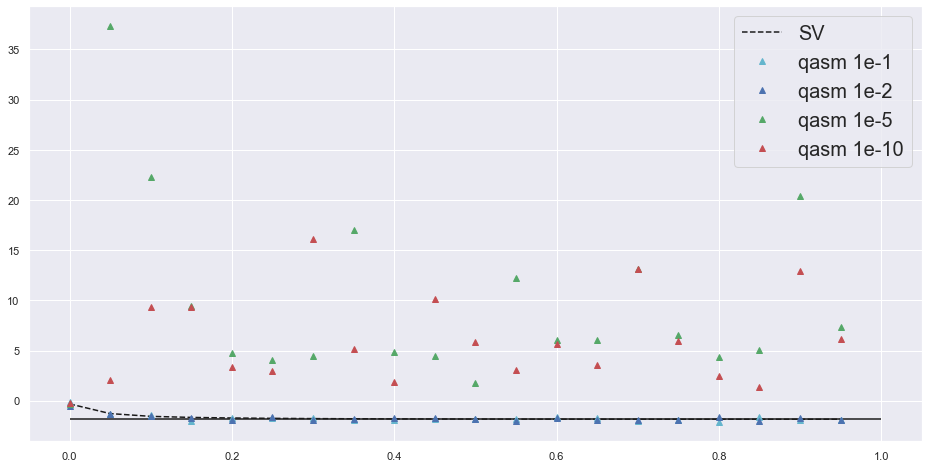

In [25]:
eig_exact=eigh(H)[0][0]
time=[delta_time*t for t in range(num_iterations)]
plt.hlines(eig_exact,0,delta_time*num_iterations,"k")
plt.plot(time,sv_energies_50,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

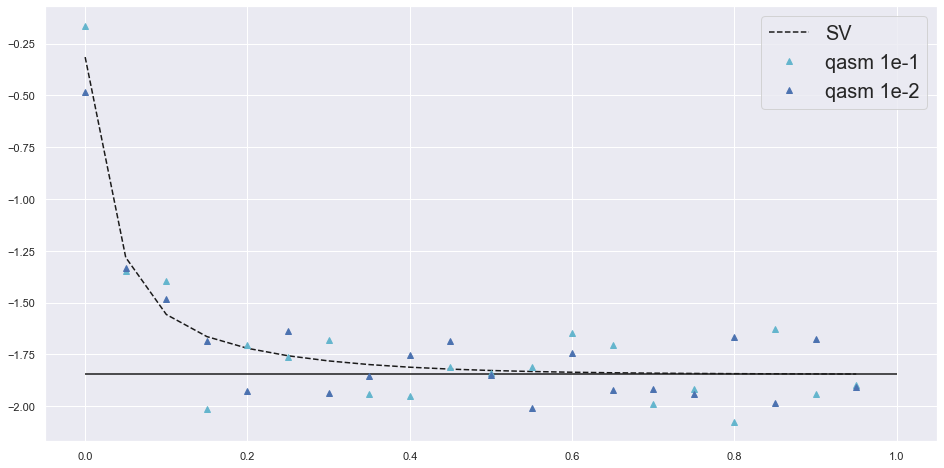

In [26]:
eig_exact=eigh(H)[0][0]
time=[delta_time*t for t in range(num_iterations)]
plt.hlines(eig_exact,0,delta_time*num_iterations,"k")
plt.plot(time,sv_energies_50,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
# plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
# plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

Testing different time steps.  Approximation of normalization coefficient requires $\Delta t\ge0.1$ 

In [24]:
num_iterations=20
verbose=False
initialization="zeros"

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

interaction_filename="../interactions/Daejeon16_Nmax40_hw15.0_rel.dat"
H = hamiltonian_matrix(Nmax=4,hw=15.0,J=1,interaction_filename=interaction_filename) 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for delta_time in [0.001,0.01]:
    backend = 'qasm_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_qasm.append(Energies)

    backend = 'statevector_simulator'
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time_sv.append(Energies)

    

 30%|███       | 6/20 [00:30<01:10,  5.01s/it]


ValueError: array must not contain infs or NaNs

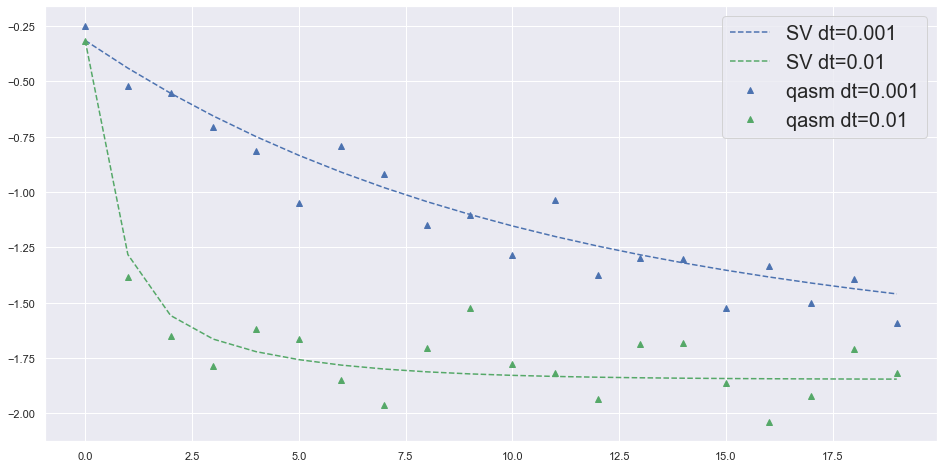

In [27]:
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
# plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
# plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

Testing merge $\{A+i\}$ into single operators after different number of iterations.

In [ ]:
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_step=[]
interaction_filename="../interactions/Daejeon16_Nmax40_hw15.0_rel.dat"
H = hamiltonian_matrix(Nmax=4,hw=15.0,J=1,interaction_filename=interaction_filename) 
H_qubit = GrayCodeHamiltonian(H)

merge_iterations=[0,1,2,10,25]
for cs in merge_iterations:
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step.append(Energies)

 98%|█████████▊| 49/50 [01:51<00:13, 13.37s/it]

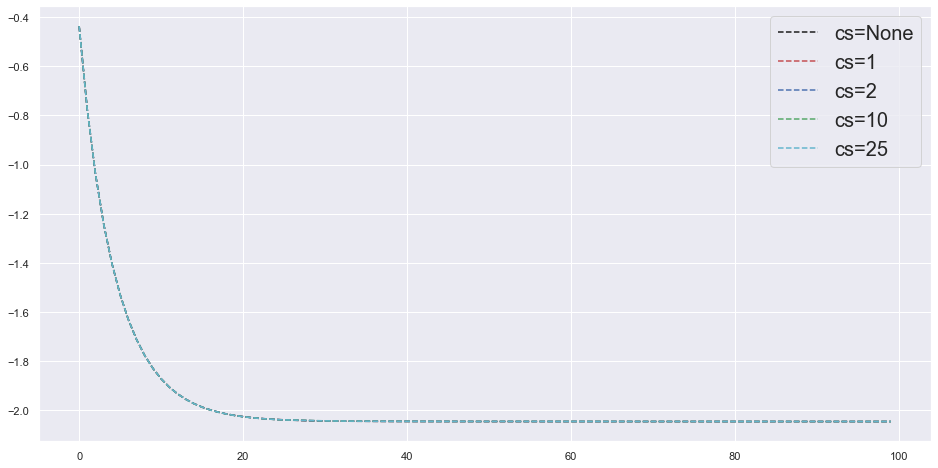

In [51]:
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r--',label="cs=1")
plt.plot(time,Energy_table_step[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step[4],'g--',label="cs=10")
plt.plot(time,Energy_table_step[4],'c--',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})


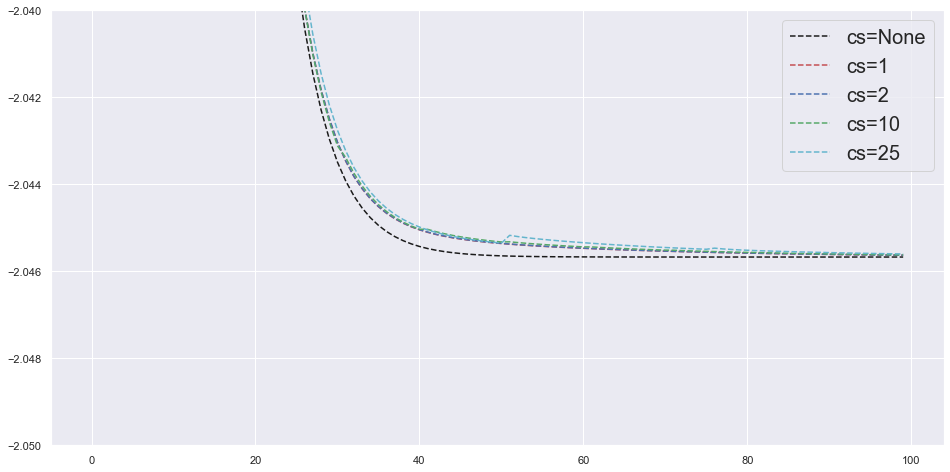

In [33]:
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r--',label="cs=1")
plt.plot(time,Energy_table_step[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step[3],'g--',label="cs=10")
plt.plot(time,Energy_table_step[4],'c--',label="cs=25")
plt.ylim(-2.05,-2.04)
plt.plot()
plt.legend(prop={'size': 20})


In [41]:
## Combining A 
num_iterations=100
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

Energy_table_step_qasm=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)


merge_iterations=[0,1,2,10,25]
for cs in merge_iterations:
    if cs==0:
        cs=None
    Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step_qasm.append(Energies)

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


[-0.48482792 -0.83589599 -1.06083362 -1.23873712 -1.44884601 -1.39243252
 -1.72164547 -1.79964929 -1.84483274 -1.72907348 -1.86435288 -1.94271644
 -1.96785939 -1.98591531 -2.0241772  -2.09720098 -2.03006991 -2.00890616
 -2.09825592 -2.12055522 -1.94625583 -2.10701473 -1.9573546  -2.23977446
 -2.17735954 -2.06342793 -1.892657   -1.95881666 -2.00815815 -1.98703626
 -2.06035752 -2.14822811 -2.00515015 -2.14718118 -1.99074137 -2.09126723
 -2.14064312 -2.12403864 -1.9034045  -2.08216039 -2.13771059 -2.05523083
 -2.05872344 -2.07383017 -1.97307164 -2.00302169 -1.86376217 -2.13519078
 -2.00978549 -1.94108799 -2.0045999  -2.152951   -2.02997816 -1.94424942
 -2.13733264 -2.08834372 -2.06404625 -1.98245339 -1.99802757 -1.93375
 -1.86078047 -2.15706679 -1.86226064 -2.04189103 -2.07584849 -2.10719708
 -2.11893737 -2.03769776 -2.12362572 -2.05188108 -1.96514857 -2.08028894
 -2.18928507 -1.90797604 -2.11284122 -2.13874651 -2.04954833 -2.0708052
 -2.04321993 -1.99539924 -2.05388464 -1.98728691 -2.014

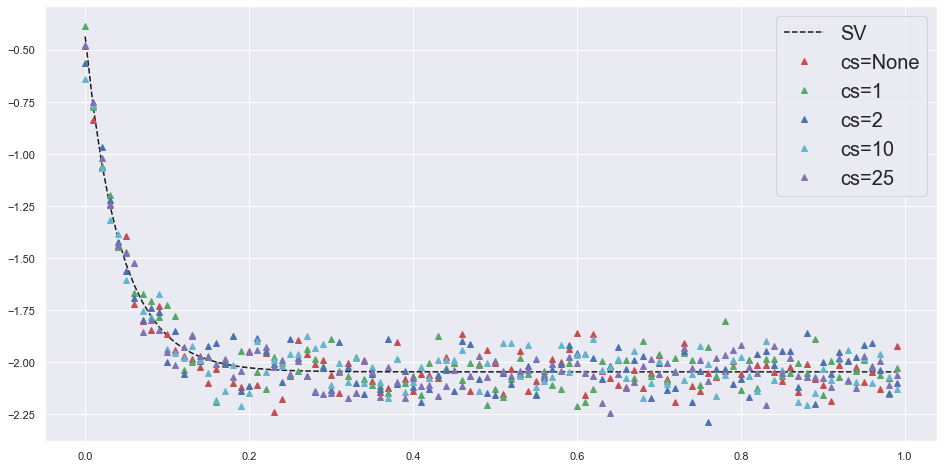

In [42]:
print(Energy_table_step_qasm[0])
time=[0.01*t for t in range(num_iterations)]
plt.plot(time,Energy_table_step[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=1")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=2")
plt.plot(time,Energy_table_step_qasm[3],'c^',label="cs=10")
plt.plot(time,Energy_table_step_qasm[4],'m^',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})

## N=8

In [22]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

H = hamiltonian_matrix(Nmax=14,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

# sv_energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)
# print(sv_energies)


3


In [52]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"
H = hamiltonian_matrix(Nmax=14,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits


Energy_table_step_3q=[]
merge_iterations=[None,1,2,10,25]
for cs in merge_iterations:
    Energy_table_step_3q.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,cstep=cs)[0])

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


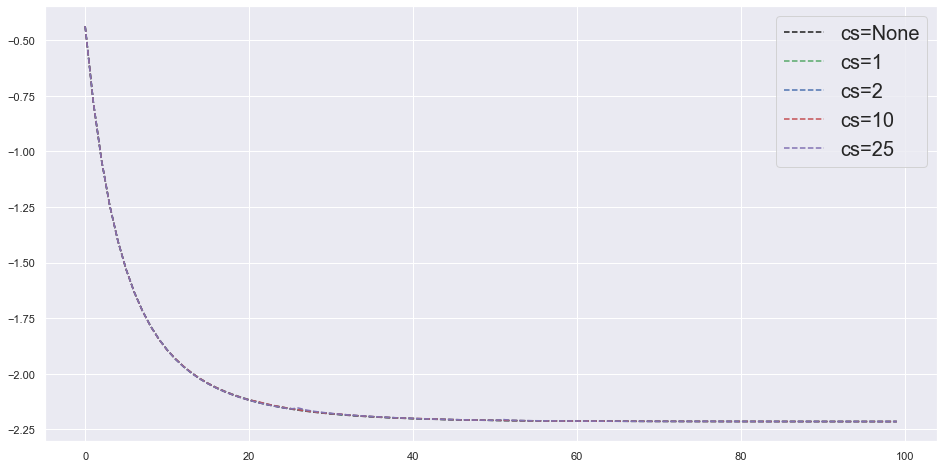

In [53]:
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.legend(prop={'size': 20})

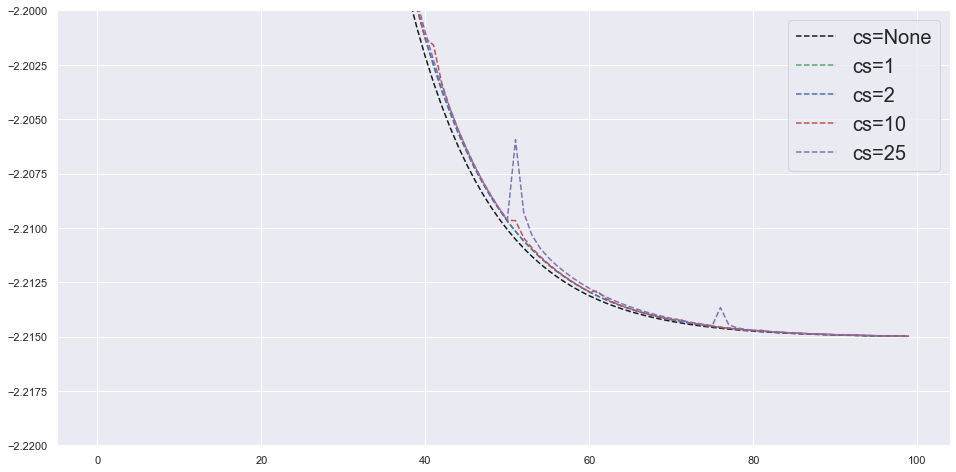

In [58]:
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.ylim(-2.22,-2.20)
plt.legend(prop={'size': 20})

In [ ]:
num_iterations=100
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=14,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_qasm_3q=[]
merge_iterations=[None,1,2,10]
for cs in merge_iterations:
    Energy_table_step_qasm_3q.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0])

 31%|███       | 31/100 [15:48<59:11, 51.48s/it]  

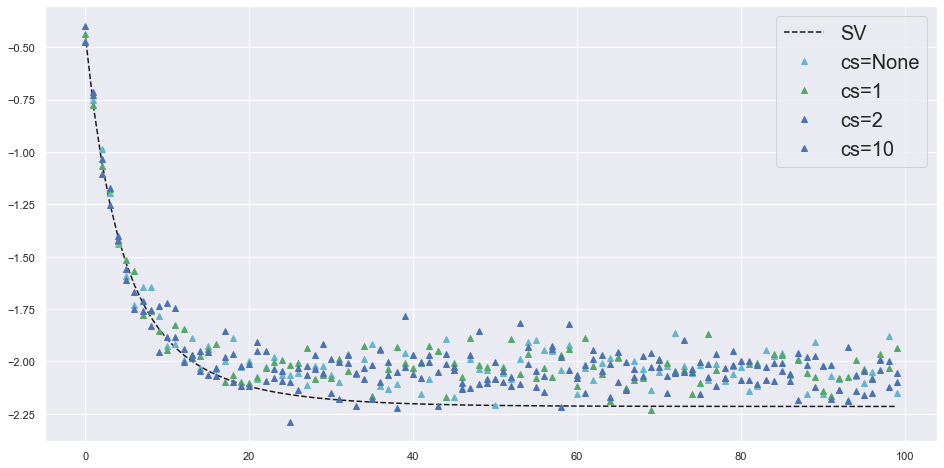

In [62]:
time=[t for t in range(num_iterations)]
plt.plot(time,Energy_table_step_3q[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm_3q[0],'c^',label="cs=None")
plt.plot(time,Energy_table_step_qasm_3q[1],'g^',label="cs=1")
plt.plot(time,Energy_table_step_qasm_3q[2],'b^',label="cs=2")
plt.plot(time,Energy_table_step_qasm_3q[3],'b^',label="cs=10")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

## Jordan Wigner

In [59]:
num_iterations=10
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=2,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_3q_jw=[]
merge_iterations=[None,1,2]
for cs in merge_iterations:
    Energy_table_step_3q_jw.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0])

100%|██████████| 10/10 [00:00<00:00, 72.40it/s]


In [ ]:
num_iterations=10
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=2,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits

Energy_table_step_3q_jw=[]
merge_iterations=[None,1,2]
for cs in merge_iterations:
    Energy_table_step_3q_jw.append(run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)[0])